In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

churn = 2

Loading datasets

In [2]:
df_train = pd.read_feather(f"../../data/processed/Churn_{churn}_train_set.feather")

In [3]:
df_train.shape

(1363984, 122)

In [4]:
df_opt = pd.read_feather(f"../../data/processed/Churn_{churn}_optimization_set.feather")

In [5]:
df_opt.shape

(684122, 122)

split X, y 

In [6]:
X_train = df_train.drop([f'BAJA_{churn}m', 'CIF_ID'], axis=1)
y_train = df_train[f'BAJA_{churn}m']
del df_train

In [7]:
X_opt = df_opt.drop([f'BAJA_{churn}m','CIF_ID'], axis=1)
y_opt = df_opt[f'BAJA_{churn}m']
del df_opt

In [8]:
cols = list(X_train.columns)

In [9]:
X_train = X_train.fillna(-999)

In [10]:
X_opt = X_opt.fillna(-999)
for col in [col for col in X_train.columns if col not in X_opt.columns]:
    X_opt[col] = -999

In [11]:
X_opt = X_opt.drop([col for col in X_opt.columns if col not in X_train.columns], axis=1)

In [12]:
for y in [y_train, y_opt]:
    print(y.value_counts(normalize=True))

False    0.98331
True     0.01669
Name: BAJA_2m, dtype: float64
False    0.97737
True     0.02263
Name: BAJA_2m, dtype: float64


In [13]:
len(X_opt.columns) 

120

In [14]:
len(X_train.columns)

120

## Training

In [15]:
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.metrics import f1_score, roc_auc_score 
from numpy.random import RandomState
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tqdm import tqdm_notebook as tqdm

In [16]:
from sklearn.utils.class_weight import compute_class_weight 

In [17]:
cw = compute_class_weight("balanced", y_train.unique(), y_train)
{i:val for i,val in enumerate(cw * (1/cw[0]))}

{0: 1.0, 1: 58.91583571271689}

In [18]:
space = {
    "algo": hp.choice("algo", [RandomForestClassifier]),
    "params": {
        "n_estimators": hp.choice("n_estimators", [40, 80, 100]),  # 100, 400
        "min_samples_leaf": hp.choice("min_samples_leaf", [5, 20, 35, 55]), # , 65
        "max_depth": hp.choice("max_depth", [5, 10, 15]), # 10,
        "max_features": hp.choice("max_features", ['sqrt', 0.5, None]),
        "class_weight": hp.choice("class_weight", [{0:1, 1:30}, {0:1, 1:40},  {0:1, 1:50}]) ,
    }
}

In [19]:
evals = 30
pbar = tqdm(total=evals)

def __optimizerFunc(args):
    pbar.update(0.5)
    print(f"Testing {args['algo']} with {args['params']['n_estimators']} estimators")
    args["params"]["verbose"] = 0
    args["params"]["n_jobs"] = -1
    args["params"]["random_state"] = 42
    model = args["algo"](**args["params"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_opt)
    pbar.update(0.5)
    # greater is better
    score = f1_score(y_opt, y_pred)
    print(f"Current Score: {score}")
    return {"loss": 1-score, "status": STATUS_OK, "config":args}
         
trials = Trials()
try:
    __bestClassifier = fmin(fn=__optimizerFunc,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=evals,
                            trials=trials,
                            rstate=RandomState(42)
                            )
except KeyboardInterrupt:
    print("Execution stopped... saving current results")
finally:
    losses = [result["loss"] for result in trials.results if result["status"] == 'ok']
    opt_config = trials.results[losses.index(min(losses))]["config"]
    pbar.close()
    print(opt_config)

Testing <class 'sklearn.ensemble.forest.RandomForestClassifier'> with 80 estimators
Current Score: 0.866524744101951
Testing <class 'sklearn.ensemble.forest.RandomForestClassifier'> with 100 estimators
Current Score: 0.9219483385657892
Testing <class 'sklearn.ensemble.forest.RandomForestClassifier'> with 100 estimators
Current Score: 0.8860453459916856
Testing <class 'sklearn.ensemble.forest.RandomForestClassifier'> with 40 estimators
Current Score: 0.8894728892916478
Testing <class 'sklearn.ensemble.forest.RandomForestClassifier'> with 80 estimators
Current Score: 0.9176128453423259
Testing <class 'sklearn.ensemble.forest.RandomForestClassifier'> with 80 estimators
Current Score: 0.9316907177515913
Testing <class 'sklearn.ensemble.forest.RandomForestClassifier'> with 40 estimators
Current Score: 0.9362540934092137
Testing <class 'sklearn.ensemble.forest.RandomForestClassifier'> with 100 estimators
Current Score: 0.9346367644239986
Testing <class 'sklearn.ensemble.forest.RandomForestCl

In [20]:
opt_config = {'params': {'class_weight': {0: 1, 1: 30}, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 40, 'verbose': 0, 'n_jobs': -1, 'random_state': 42}}

In [21]:
# rf = opt_config['algo'](**opt_config['params'])
rf = RandomForestClassifier(**opt_config['params'])

In [22]:
rf

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
                       criterion='gini', max_depth=15, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

rf = RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
                       criterion='gini', max_depth=15, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [23]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
                       criterion='gini', max_depth=15, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

---

### Feature importance

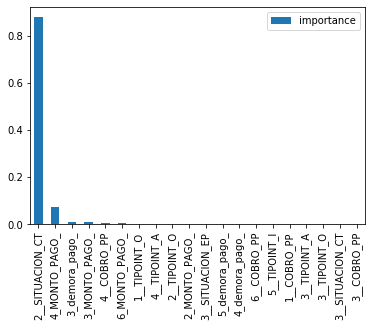

In [24]:
pd.DataFrame(rf.feature_importances_,index=X_train.columns, columns=['importance']
                                   ).sort_values('importance', ascending=False).iloc[0:20].plot.bar()

**METRICS**

In [25]:
df_val = pd.read_feather(f"../../data/processed/Churn_{churn}_validation_set.feather")

In [26]:
X_val = df_val.drop([f'BAJA_{churn}m','CIF_ID'], axis=1)
y_val = df_val[f"BAJA_{churn}m"]
del df_val

In [27]:
X_val = X_val.fillna(-999)
for col in [col for col in X_train.columns if col not in X_val.columns]:
    X_val[col] = -999

In [28]:
X_val = X_val.drop([col for col in X_val.columns if col not in X_train.columns], axis=1)

In [29]:
len(X_val.columns)

120

In [30]:
predictions = rf.predict(X_val)
pd.Series(predictions).value_counts()

False    664388
True      15214
dtype: int64

In [31]:
import seaborn as sns

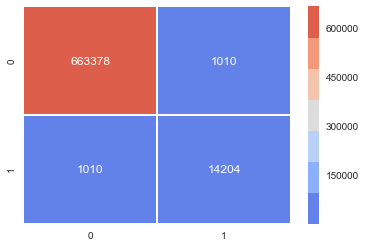

In [32]:
cmap = sns.color_palette("coolwarm", 7)
sns.set(font_scale=1)
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt="d", linewidths=.5, cmap=cmap) 

In [33]:
print(f'ROC AUC: {roc_auc_score(y_val, predictions)} ') 

ROC AUC: 0.9660467903772549 


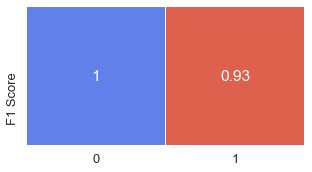

In [34]:
data = pd.DataFrame(columns=range(2), data=[f1_score(y_val, predictions, average=None)])
data.index = ["F1 Score"]
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(5,5))
sns.set(font_scale=1.3)
cmap = sns.color_palette("coolwarm_r", 7)
sns.heatmap(data, annot=True, linewidths=.5, cmap=cmap, square=True, cbar=False)

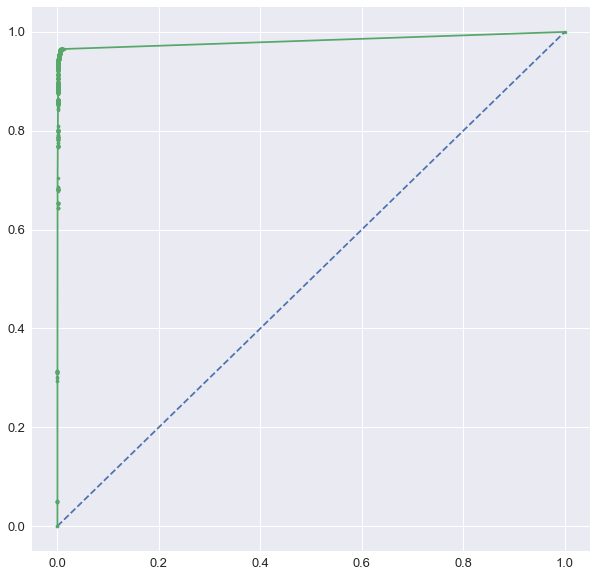

In [35]:
from sklearn.metrics import roc_curve

probs = rf.predict_proba(X_val)
probs = probs[:, 1]
fig=plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(y_val, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Dumping model

In [36]:
import pickle

In [37]:
with open(f'../../src/models/Churn{churn}-Hyperotimization-Numeric.md', 'wb') as file:
    pickle.dump(rf, file, pickle.HIGHEST_PROTOCOL)